# Update Rule

In [12]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Config

In [ ]:
# Experimental setup arguments

class args:

    alpha = 0.2
    delta = 0.1
    epsilon = 0.01  # move it is movement in model output (rather than input) and much larger than before
    N = 1000  # number of samples in cohort (1000 vs. 10,000)

    T = 5

    lambda_max = 1  # maximum conservativeness

    tau = 10  # safety parameter
    L = 10  # Lipschitz constant

### Model

In [32]:
from data_prep import load_data

path_to_csv_file = './data/cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

n_training = 3000
X_train, X_rest, Y_train, Y_rest = train_test_split(X_all, Y_all, train_size=n_training, random_state=42)

d = X_all.shape[1] - 1
print('d=',d)

del X_all, Y_all

X_cv, Y_cv = X_rest, Y_rest

d= 10


In [33]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


In [34]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

In [35]:
model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)

[[-0.01667921 -0.37893437  1.50033032 -0.02584675 -0.51045365  0.01061577
   1.16945097  0.13462701 -0.68275283  0.15147358 -0.32419056]]


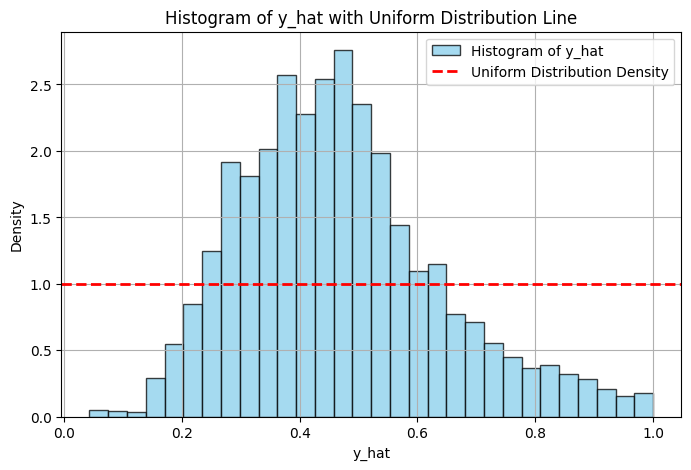

In [36]:
Y_hat = model.predict_proba(X_train)[:,1]


import matplotlib.pyplot as plt

# Assuming y_hat is already defined and contains values between 0 and 1
# Example: y_hat = np.random.uniform(0, 1, N)

plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(Y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat with Uniform Distribution Line')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# Experiment

In [37]:
def type_II_error(Y, Y_proba, threshold):
    """Y=actual, Y_proba=predicted probability, threshold=threshold"""
    return np.mean((Y == 1) * (Y_proba < 1. - threshold))


def piecewise_fn(Y_proba: np.ndarray, thresh: int):
    # clipping assumes loss btwn 0 and 1

    # lower_bound = (1 - thresh) - 1 / args.L
    # upper_bound = 1 - thresh
    # y = np.where(Y_proba < lower_bound, 1, 
    #              np.where(Y_proba > upper_bound, 0, 
    #                       1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L)))

    # Optimization 1: use np.clip
    # y = np.clip(1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L), 0, 1)

    # Optimization 2: compute less
    assert len(Y_proba.shape) == 1
    return np.clip(args.L * (1 - thresh - Y_proba), 0, 1)


def piecewise_loss(Y, Y_proba, thresh):
    assert len(Y.shape) == 1
    assert len(Y_proba.shape) == 1
    return ((Y == 1) * piecewise_fn(Y_proba, thresh))


def surrogate_loss(Y, Y_proba, thresh):
    """l_{\tilde}"""
    return piecewise_loss(Y, Y_proba, thresh) + args.tau * (args.lambda_max - thresh)


# def modify(Y_proba, threshold):
#     in_move_range = np.logical_and(1 - threshold <= Y_proba, Y_proba <= 1 - threshold + args.epsilon)
#     Y_proba_new = Y_proba.copy()
#     Y_proba_new[in_move_range] -= args.epsilon
#     return Y_proba_new

In [46]:
# def approx_distribution_shift(X, model, thresh):
#     # most significant feature
#     feature = np.argmax(np.abs(model.coef_))
#     sign = np.sign(model.coef_[0, feature])

#     # shift X by args.epsilon in that feature
#     X_shifted = X.copy()
#     X_shifted[:, feature] -= sign * args.epsilon

#     # does shifting X change the prediction?
#     Y_proba = model.predict_proba(X)[:, 1]
#     Y_proba_shifted = model.predict_proba(X_shifted)[:, 1]

#     # does shifting cause Y_proba to cross 1 - thresh?
#     in_move_range = np.logical_and(1 - thresh <= Y_proba, Y_proba_shifted <= 1 - thresh)

#     # shift only those in the move range
#     return np.where(in_move_range, X_shifted, X)


def get_new_features(X, model, thresh):
    # toy "optimization", either stay w/ current features or move by epsilon
    # to new features, depending on which has higher utility cost

    s = np.abs(model.coef_).argmax()
    onehot = np.zeros((1, len(model.coef_[0])))
    onehot[0, s] = 1
    sign = np.sign(model.coef_[0, s])

    # utility of not moving
    stay_utility_cost = np.squeeze(1 - piecewise_fn(model.predict_proba(X)[:,1], thresh))

    # utility of moving by epsilon
    X_move = X + sign * args.epsilon * onehot

    move_utility = np.squeeze(1 - piecewise_fn(model.predict_proba(X_move)[:,1], thresh))
    move_cost = (1 / (2 * args.epsilon / args.L) * np.square(X_move - X)).sum(axis=1)
    move_utility_cost = move_utility - move_cost

    mask = move_utility_cost > stay_utility_cost

    result = np.where(mask[:, np.newaxis], X_move, X)
    return result


In [44]:
def secant_solver(objective, lam0, lam1, tol=1e-6, max_iter=100):
    f0 = objective(lam0)
    f1 = objective(lam1)
    print(f"lam0: {lam0}, lam1: {lam1}, f0: {f0}, f1: {f1}")
    for _ in range(max_iter):
        if abs(f1) < tol:
            return lam1
        # Update using the secant method formula.
        lam_new = lam1 - f1 * (lam1 - lam0) / (f1 - f0)
        lam0, f0 = lam1, f1
        lam1 = lam_new
        f1 = objective(lam1)
    return lam1



def binary_search_solver(objective, lam_low, lam_high, tol=1e-6, max_iter=100):
    if objective(lam_low) <= 0:
        return lam_low
    
    if objective(lam_high) > 0:
        raise ValueError("No crossing found: objective > 0 for all λ in [lam_low, lam_high].")

    for _ in range(max_iter):
        mid = (lam_low + lam_high) / 2.0
        if objective(mid) <= 0:
            lam_high = mid
        else:
            lam_low = mid
        if lam_high - lam_low < tol:
            break
    return lam_high

In [47]:
def get_next_thresh(Y, Y_proba):
    def objective(thresh):
        return np.mean(surrogate_loss(Y, Y_proba, thresh)) - args.alpha

    return binary_search_solver(objective, 0, args.lambda_max)

In [45]:
np.sqrt(np.log(2/args.delta*5) / args.N)

np.float64(0.06786140424415112)

In [48]:
from tqdm import tqdm


def run_trajectory(X, Y, lam_init = 1., verbose=False):

    losses = []
    threshes = []

    thresh = args.lambda_max

    iters = tqdm(range(1, args.T + 1)) if verbose else range(1, args.T + 1)
    for t in iters:

        # Deploy threshold
        X_i = get_new_features(X, model, thresh)
        Y_proba_i = model.predict_proba(X_i)[:, 1]

        # Calculate loss
        err = type_II_error(Y, Y_proba_i, thresh)
        loss_t = np.mean(piecewise_loss(Y, Y_proba_i, thresh))
        surrogate_loss_t = np.mean(surrogate_loss(Y, Y_proba_i, thresh))

        # Update threshold
        thresh_new = get_next_thresh(Y, Y_proba_i)

        losses.append((err, loss_t, surrogate_loss_t))
        threshes.append(thresh)
    
    return losses, threshes

### Run

In [207]:
args.alpha = 0.2
Y_proba = model.predict_proba(X_cv)[:,1]
Y = Y_cv
lam, lams_naive, lams_aware, lams = run_trajectory(Y, Y_proba, lam_init = 1.0, num_iters=100)

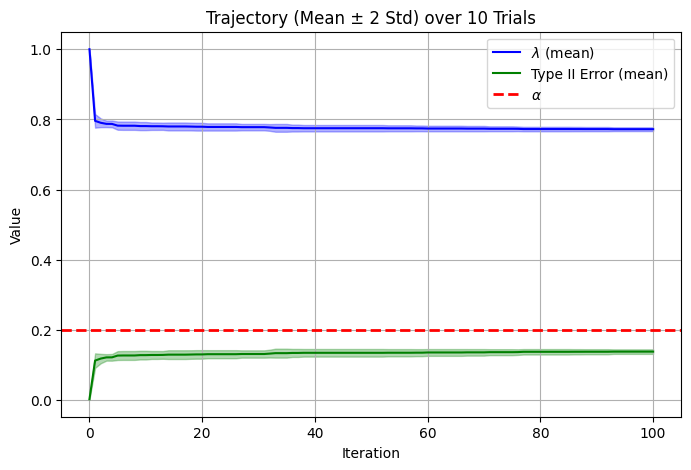

In [209]:
import numpy as np
import matplotlib.pyplot as plt

# Number of trials
num_trials = 10
num_iters = 100

# Containers for trajectories and type II error trajectories
all_lams = []          # To store lambda trajectories (each of length num_iters)
all_typeII = []        # To store type II error trajectories (each of length num_iters)

for trial in range(num_trials):
    # Run a single trial (assumes run_trajectory, type_II_error, and modify are defined)
    lam, lams_naive, lams_aware, lams = run_trajectory(Y, Y_proba, lam_init=1.0, num_iters=num_iters)
    
    # Record the lambda trajectory
    all_lams.append(lams)
    
    # Compute type II error at each iteration
    typeII_errors = [type_II_error(Y, modify(Y_proba, lam_val), lam_val) for lam_val in lams]
    all_typeII.append(typeII_errors)

# Convert lists to numpy arrays for easier computation
all_lams = np.array(all_lams)         # shape: (num_trials, num_iters)
all_typeII = np.array(all_typeII)       # shape: (num_trials, num_iters)

# Compute mean and standard deviation across trials for each iteration
mean_lams = np.mean(all_lams, axis=0)
std_lams = np.std(all_lams, axis=0)
mean_typeII = np.mean(all_typeII, axis=0)
std_typeII = np.std(all_typeII, axis=0)

# Prepare x-axis as iteration indices
iterations = np.arange(1 + num_iters)

# Plot the mean trajectories with standard deviation shading
plt.figure(figsize=(8, 5))

# Plot lambda trajectory
plt.plot(iterations, mean_lams, label=r'$\lambda$ (mean)', color='blue')
plt.fill_between(iterations, mean_lams - 2 * std_lams, mean_lams + 2 * std_lams, 
                 color='blue', alpha=0.3)

# Plot type II error trajectory
plt.plot(iterations, mean_typeII, label='Type II Error (mean)', color='green')
plt.fill_between(iterations, mean_typeII - 2 * std_typeII, mean_typeII + 2 * std_typeII, 
                 color='green', alpha=0.3)

# Plot horizontal line for alpha (assumes args.alpha is defined)
plt.axhline(y=args.alpha, color='red', linestyle='--', linewidth=2, label=r'$\alpha$')

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trajectory (Mean ± 2 Std) over {} Trials'.format(num_trials))
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
